In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import argparse
from copy import deepcopy
import logging
from matplotlib import font_manager
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.integrate import solve_ivp
from sklearn.metrics import r2_score
import sys
import torch
from tqdm.auto import tqdm

sys.path.append('../..')
from data_utils import *
from plot_utils import *

from delase import DeLASE
# from parameter_choosing import *
from delase.metrics import *

plt.style.use('../../sci_style.py')
font_path = "/om2/user/eisenaj/miniforge3/envs/communication-transformer/fonts/arial.ttf"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

In [3]:
def rnn(t, x, W, tau, g):
    return (1/tau)*(-x + g*W @ np.tanh(x))

def rnn_jacobian(x, W, g, tau, dt, use_torch=False, device='cpu', dtype='torch.DoubleTensor'):
    if use_torch:
        I = torch.eye(x.shape[1]).type(dtype).to(device)
        if len(x.shape) == 1:
            return I + (dt/tau)*(-I + (g*W @ torch.diag(1 - torch.tanh(x)**2)))
        else:
            return I.unsqueeze(0) + (dt/tau)*(-I.unsqueeze(0) + (g*W*((1 - torch.tanh(x)**2).unsqueeze(1))))
    else:
        if len(x.shape) == 1:
            return np.eye(N) + (dt/tau)*(-np.eye(N) + (g*W @ np.diag(1 - np.tanh(x)**2)))
        else:
            print((1 - np.tanh(x)**2)[:, np.newaxis].shape)
            return np.eye(N)[np.newaxis] + (dt/tau)*(-np.eye(N)[np.newaxis] + (g*W*(1 - np.tanh(x)**2)[:, np.newaxis]))

def compute_lyaps(Js, dt=1, k=None, worker_num=None, message_queue=None, verbose=False):
    T, n = Js.shape[0], Js.shape[1]
    old_Q = np.eye(n)
    if k is None:
        k = n
    old_Q = old_Q[:, :k]
    lexp = np.zeros(k)
    lexp_counts = np.zeros(k)
    for t in tqdm(range(T), disable=not verbose):
        # QR-decomposition of Js[t] * old_Q
        mat_Q, mat_R = np.linalg.qr(np.dot(Js[t], old_Q))
        # force diagonal of R to be positive
        # (if QR = A then also QLL'R = A with L' = L^-1)
        sign_diag = np.sign(np.diag(mat_R))
        sign_diag[np.where(sign_diag == 0)] = 1
        sign_diag = np.diag(sign_diag)
#         print(sign_diag)
        mat_Q = np.dot(mat_Q, sign_diag)
        mat_R = np.dot(sign_diag, mat_R)
        old_Q = mat_Q
        # successively build sum for Lyapunov exponents
        diag_R = np.diag(mat_R)

#         print(diag_R)
        # filter zeros in mat_R (would lead to -infs)
        idx = np.where(diag_R > 0)
        lexp_i = np.zeros(diag_R.shape, dtype="float32")
        lexp_i[idx] = np.log(diag_R[idx])
#         lexp_i[np.where(diag_R == 0)] = np.inf
        lexp[idx] += lexp_i[idx]
        lexp_counts[idx] += 1

        # it may happen that all R-matrices contained zeros => exponent really has
        # to be -inf

        # normalize exponents over number of individual mat_Rs
#         idx = np.where(lexp_counts > 0)
        #lexp[idx] /= lexp_counts[idx]
#         lexp[np.where(lexp_counts == 0)] = np.inf

        if message_queue is not None:
            message_queue.put((worker_num, "task complete", "DEBUG"))
    
    return np.divide(lexp, lexp_counts)*(1/dt)

def compute_lyaps_and_jacobians(x, W, g, tau, dt, k=None, use_torch=False, device='cpu', dtype='torch.DoubleTensor', worker_num=None, message_queue=None, verbose=False):
    T, n = x.shape[0], x.shape[1]
    old_Q = np.eye(n)
    if k is None:
        k = n
    old_Q = old_Q[:, :k]
    lexp = np.zeros(k)
    lexp_counts = np.zeros(k)
    for t in tqdm(range(T), disable=not verbose):
        J = rnn_jacobian(x[t], W, g, tau, dt, use_torch, device, dtype)
        # QR-decomposition of Js[t] * old_Q
        mat_Q, mat_R = np.linalg.qr(np.dot(J, old_Q))
        # force diagonal of R to be positive
        # (if QR = A then also QLL'R = A with L' = L^-1)
        sign_diag = np.sign(np.diag(mat_R))
        sign_diag[np.where(sign_diag == 0)] = 1
        sign_diag = np.diag(sign_diag)
#         print(sign_diag)
        mat_Q = np.dot(mat_Q, sign_diag)
        mat_R = np.dot(sign_diag, mat_R)
        old_Q = mat_Q
        # successively build sum for Lyapunov exponents
        diag_R = np.diag(mat_R)

#         print(diag_R)
        # filter zeros in mat_R (would lead to -infs)
        idx = np.where(diag_R > 0)
        lexp_i = np.zeros(diag_R.shape, dtype="float32")
        lexp_i[idx] = np.log(diag_R[idx])
#         lexp_i[np.where(diag_R == 0)] = np.inf
        lexp[idx] += lexp_i[idx]
        lexp_counts[idx] += 1

        # it may happen that all R-matrices contained zeros => exponent really has
        # to be -inf

        # normalize exponents over number of individual mat_Rs
#         idx = np.where(lexp_counts > 0)
        #lexp[idx] /= lexp_counts[idx]
#         lexp[np.where(lexp_counts == 0)] = np.inf

        if message_queue is not None:
            message_queue.put((worker_num, "task complete", "DEBUG"))
    
    return np.divide(lexp, lexp_counts)*(1/dt)

In [4]:
save_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness"

In [5]:
chaotic_net_path = "/scratch2/weka/millerlab/eisenaj/DynamicalTrajectories/chaotic_net_data"

W = pd.read_pickle(os.path.join(chaotic_net_path, "W.pkl"))

In [6]:
# g_vals = [0.75, 0.8, 0.85, 0.9, 0.925, 0.95, 0.975, 1, 1.025, 1.05, 1.075, 1.1, 1.125, 1.15, 1.175, 1.2, 1.25, 1.3, 1.35, 1.4, 1.5, 1.6, 1.7, 1.8]
g_vals = [0.8, 0.9, 1, 1.2, 1.3, 1.4]

In [7]:
NUM_RUNS = 1

In [8]:
# def g_dW(x):
#     return 0.05

# for run_num in tqdm(range(NUM_RUNS)):
    
#     print("="*40)
#     print(f"RUN_NUM = {run_num}")
#     print("="*40)

#     signals = {}
#     lyaps = {}

#     np.random.seed(42 + run_num)

#     print("Simulating signals...")
#     W = np.random.randn(N, N)/np.sqrt(N)
#     for g in tqdm(g_vals):
#         dW = np.sqrt(dt) * np.random.randn(T,N)
#         x0 = np.random.randn(N)
#          # Define the function g(x)
        

#         # Initialize the x array
#         x = np.zeros((T, N))
#         x[0] = np.random.randn(N)

#         # Simulate the stochastic differential equation
#         for i in range(1, T):
#             x[i] = x[i-1] + rnn((i - 1)*dt, x[i-1], W, tau, g) * dt + g_dW(x[i-1]) * dW[i]
            
#         signals[g] = x
#     print("Signals simulated!")

#     print("MAIN ANALYSIS:")
#     for key in tqdm(g_vals):
#         print("-"*20)
#         print(f"g = {key}")
#         print("-"*20)
#         signal = signals[g]
#         g = key

#         # Js = np.zeros((signal.shape[0], N, N))
#         # print("Computing Jacobians..")
#         # for batch_num in tqdm(range(num_batches)):
#         #     start_ind = batch_num*batch_size
#         #     end_ind = np.min([(batch_num + 1)*batch_size, signal.shape[0]])
#         #     batch_Js = rnn_jacobian(signal[start_ind:end_ind], W, g, tau, dt, N, use_torch=use_torch, device=device)
#         #     if device == 'cuda':
#         #         batch_Js = batch_Js.cpu()
#         #     Js[start_ind:end_ind] = batch_Js

#         # print("Computing Lyaps...")
#         # lyaps[key] = compute_lyaps(Js, dt=dt, k=3, verbose=True)
        
#         lyaps[key] = compute_lyaps_and_jacobians(signal, W, g, tau, dt, k=3, use_torch=False, device='cpu', verbose=True)

#     ret = dict(
#         W=W,
#         lyaps=lyaps,
#         signals=signals,
#         dt=dt,
#         tau=tau,
#         N=N,
#         T=T
#     )
#     # pd.to_pickle(ret, os.path.join(chaotic_net_folder, f"RUN_{run_num}"))

In [9]:
chaotic_net_folder = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/chaotic_nets/chaotic_nets_multirun_stochastic_1024'

In [10]:
run_num = 2
run_ret = pd.read_pickle(os.path.join(chaotic_net_folder, f"RUN_{run_num}"))

# Compute Dynamical Models

In [ ]:
# parameter_grid = ParameterGrid(
#     window_vals=np.array([10000]),
#     matrix_size_vals=np.array([50, 100, 150, 200, 300, 400, 500, 750, 1000, 1500, 2000]),
#     r_vals = np.array([3, 5, 10, 25, 50, 75, 100, 125, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 900, 1000, 1200, 1400, 1600, 1800])
# )

prediction_time = 4000
transient = 2000
window = 10000

# num_indices_list = [2, 10, 20, 30, 40, 50]
num_indices_list = [10]

class ParameterGrid:
    def __init__(self, window_vals, matrix_size_vals, r_vals):
        self.window_vals = window_vals
        self.matrix_size_vals = matrix_size_vals
        self.r_vals = r_vals

parameter_grid = ParameterGrid(
    window_vals=np.array([10000]),
    matrix_size_vals=np.array([2, 5, 10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 350, 400]),
    r_vals = np.array([2, 3, 5, 10, 30, 40, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400])
)
device='cuda'

noise_sd = 0

In [ ]:

use_torch = True

In [ ]:
# np.random.seed(42 + run_num)

# all_index_rets = {}
# parameter_grid_orig = deepcopy(parameter_grid)
# for num_indices in num_indices_list:
#     print(f"num_indices = {num_indices}")
#     parameter_grid.matrix_size_vals = parameter_grid_orig.matrix_size_vals[parameter_grid_orig.matrix_size_vals >= num_indices]
#     if num_indices < 10:
#         parameter_grid.matrix_size_vals = parameter_grid.matrix_size_vals[parameter_grid.matrix_size_vals <= 50*num_indices]
#     indices = np.random.choice(np.arange(N), size=(num_indices, ), replace=False)

#     full_signals = run_ret['signals']
#     signals = {key: full_signal[:, indices] for key, full_signal in full_signals.items()}
#     keys = list(signals.keys())
#     for key in signals.keys():
#         signals[key] += np.random.randn(T, len(indices))*noise_sd

#     # VAR
#     A_mats = {}
#     criticality_inds = {}
#     AIC_VAR_normed = {}
#     pb_AIC = {}
#     for key, signal in tqdm(signals.items(), total=len(signals)):
#         train_signal = signal[transient:transient + window]
#         test_signal = signal[transient + window:transient + window + prediction_time]

#         A_VAR = np.linalg.lstsq(train_signal[:-1], train_signal[1:], rcond=1e-20)[0].T
#         A_mats[key] = A_VAR
#         criticality_inds[key] = np.sort(np.abs(np.linalg.eigvals(A_VAR)))[::-1]
#         n_pts = test_signal.shape[0] - 1
#         preds = (A_VAR@test_signal[:-1].T).T
#         AIC_VAR_normed[key] = float(n_pts*np.log(((preds - test_signal[1:])**2).sum()/n_pts) + 2*(A_VAR.shape[0]*A_VAR.shape[1] + 1))/n_pts
#         pb_AIC[key] = float(n_pts*np.log(((test_signal[:-1] - test_signal[1:])**2).sum()/n_pts))/n_pts
#     print("Computing DeLASE...")
#     results = []
#     iterator = tqdm(total=len(parameter_grid.window_vals)*len(parameter_grid.matrix_size_vals)*len(parameter_grid.r_vals))
#     for window in parameter_grid.window_vals:
#         for matrix_size in parameter_grid.matrix_size_vals:
#             delases = {}
#             exp_variances = {}
#     #         train_signals = []
#             test_signals = {}
#             for key, signal in signals.items():
#                 train_signal = signal[transient:transient + window]
#                 test_signal = signal[transient + window:transient + window + prediction_time]
#                 delase = DeLASE(train_signal, matrix_size=matrix_size, dt=dt, device=device)
#                 delase.DMD.compute_hankel()
#                 delase.DMD.compute_svd()
#                 delase.to('cpu')
#                 # exp_variances[key] = delase.DMD.cumulative_explained_variance.cpu().double()
#                 delases[key] = delase
#     #             train_signals.append(train_signal)
#                 test_signals[key] = test_signal
#             for r in parameter_grid.r_vals:
#                 if r <= np.min([delase.n*delase.n_delays for delase in delases.values()]):
#                     stab_curves = {}
#                     AICs = {}
#                     for key, delase in delases.items():
#                         delase.to(device)
#                         delase.DMD.compute_havok_dmd(rank=r)
#                         delase.get_stability(max_freq=500, max_unstable_freq=125)

#                         AICs[key] = compute_AIC(delase, test_signals[key], norm=True)
#                         if use_torch:
#                             stab_curves[key] = delase.stability_params.cpu()
#                         else:
#                             stab_curves[key] = delase.stability_params

#                     exp_variances = np.array([delase.DMD.cumulative_explained_variance[r-1].cpu().numpy() for delase in delases.values()])
    
#                     results.append(dict(
#                         window=window,
#                         matrix_size=matrix_size,
#                         r=r,
#                         exp_variances=exp_variances,
#                         AICs=AICs,
#                         stab_curves=stab_curves,
#                     ))

#                 iterator.update()
#     iterator.close()

#     results = pd.DataFrame(results)
#     results_dict = {}
#     for key in signals.keys():
#         ret_temp = results.copy()
#         ret_temp = ret_temp.drop('AICs', axis=1)
#         ret_temp = ret_temp.drop('stab_curves', axis=1)
#         ret_temp = ret_temp.drop('exp_variances', axis=1)
#         ret_temp['AIC'] = results.AICs.apply(lambda x: x[key])
#         ret_temp['stab_curves'] = results.stab_curves.apply(lambda x: x[key])
#         ret_temp = ret_temp.set_index((['window', 'matrix_size', 'r']))
#         results_dict[key] = ret_temp


#     all_index_rets[num_indices] = dict(
#         delase=results_dict,
#         VAR=dict(
#             A_mats=A_mats,
#             criticality_inds=criticality_inds,
#             AIC_VAR_normed=AIC_VAR_normed
#         ),
#         pb=dict(
#             AIC=pb_AIC
#         )
#     )
    
# # pd.to_pickle(all_index_rets, os.path.join(chaotic_net_folder, f"{f}_dynamics"))

In [12]:
num_indices = 10

In [13]:
dynamic_rets = pd.read_pickle(os.path.join(chaotic_net_folder, f"RUN_{run_num}_dynamics"))[num_indices]

In [14]:
g_min = 0.8
g_max = 1.2

In [15]:
window, matrix_size, r, all_results = combine_grid_results({key: dynamic_rets['delase'][key] for key in dynamic_rets['delase'].keys() if key >= g_min and key <= g_max})

In [16]:
stab_curves = {key: dynamic_rets['delase'][key].loc[(window, matrix_size, r)].stab_curves for key in dynamic_rets['delase'].keys() if key >= g_min and key <= g_max}

In [17]:
lyaps = {key: run_ret['lyaps'][key][0] for key in run_ret['lyaps'].keys() if key >= g_min and key <= g_max}

In [18]:
g1, g2 = 1.075, 1.2

In [19]:
lyaps[g1], lyaps[g2]

(-2.8169060738682106, -3.102217704582727)

In [20]:
stab_curves[g1][:int(0.1*len(stab_curves[g1]))].mean(), stab_curves[g2][:int(0.1*len(stab_curves[g2]))].mean()

(tensor(-10.2714), tensor(-9.3505))

In [21]:
[len(stab_curve) for stab_curve in stab_curves.values()]

[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]

In [ ]:
top_percent = 0.02
ax = plt.gca()
ax.plot(list(lyaps.keys()), list(lyaps.values()))
ax2 = ax.twinx()
ax2.plot(list(lyaps.keys()), [stab_curve[:int(top_percent*len(stab_curve))].mean() for stab_curve in stab_curves.values()], linestyle='--', c='k')
ax2.plot(list(lyaps.keys()), [stab_curve[:int(top_percent*len(stab_curve))].mean() for stab_curve in stab_curves.values()], linestyle='--', c='k')

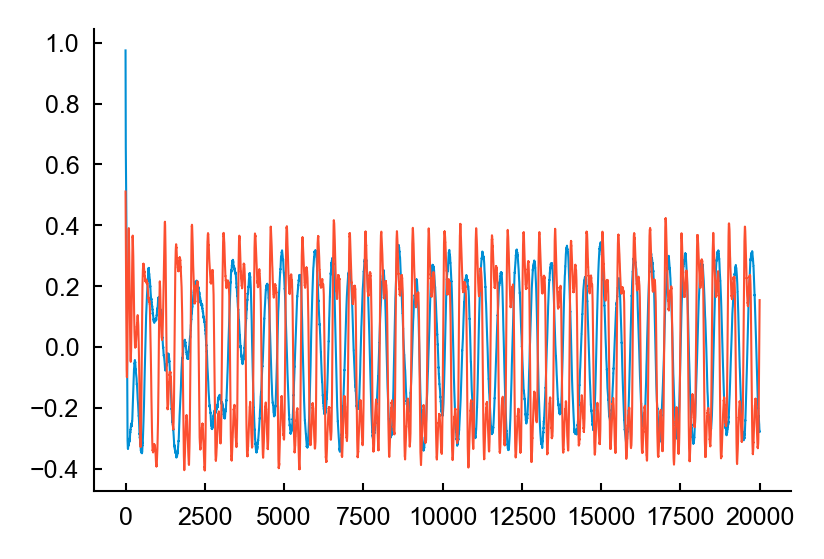

In [39]:
plt.plot(run_ret['signals'][g1][:, 0])
plt.plot(run_ret['signals'][g2][:, 0])